### Evaluate final U-Net models on CESM, FOCI and real world slp data

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    clone_data, 
    create_missing_mask, 
    split_and_scale_data,
    area_mean_weighted,
    spatial_mask,
)
from models import build_unet_4conv
from indices import (
    southern_annular_mode_zonal_mean,
    north_atlantic_oscillation_station,
    north_pacific,
)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Check current working directory:
print(os.getcwd())

/work/GitHub/MarcoLandtHayen/reconstruct_missing_data/notebooks


In [3]:
# Set working directory, according to working directory in scripts:
# os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
os.chdir('/work') # local in Docker Container

In [4]:
## Specify parameters:

# Source: 'CESM', 'FOCI' or 'realworld'
source = 'realworld'
feature_short = 'slp'

# Further parameters for pre-processing inputs and targets:
train_val_split = 0.8
scale_to = 'zero_one'


## Set paths to final models and set shortnames for final models:

if source == 'realworld':

    # realworld:
    paths_to_final_models=[
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_fixed_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_2_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_variable_discrete_factor_3_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_CESM_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_optimal_from_FOCI_discrete_factor_1_final',
    ]
    
    model_shortnames=[
        'mask: fixed',
        'mask: variable, factor: 1',
        'mask: variable, factor: 2',
        'mask: variable, factor: 3',
        'mask: optimal from CESM',
        'mask: optimal from FOCI',
    ]
    
else:
    
    paths_to_final_models=[
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_fixed_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_variable_discrete_factor_1_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_variable_discrete_factor_2_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_variable_discrete_factor_3_final',
        'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_'+source+'_optimal_discrete_factor_1_final',
    ]

    model_shortnames=[
        'mask: fixed',
        'mask: variable, factor: 1',
        'mask: variable, factor: 2',
        'mask: variable, factor: 3',
        'mask: optimal',
    ]

In [5]:
# Load train and validation loss per sample for first model, to infer number of training and validation samples, 
# lat and lon, and number of missing value rates. Do this from first experiment, since it has augmentation factor 1:
n_train=np.load(Path(paths_to_final_models[0]) / 'train_loss_per_sample_all.npy').shape[-1]
n_val=np.load(Path(paths_to_final_models[0]) / 'val_loss_per_sample_all.npy').shape[-1]
lat=np.load(Path(paths_to_final_models[0]) / 'train_loss_map_all.npy').shape[1]
lon=np.load(Path(paths_to_final_models[0]) / 'train_loss_map_all.npy').shape[2]
n_missing=np.load(Path(paths_to_final_models[0]) / 'train_loss_per_sample_all.npy').shape[0]

# Initialize storage for parameters:
feature_all = []
feature_short_all = []
source_all = []
mask_type_all = []
missing_type_all = []
augmentation_factor_all = []
missing_values_all = []

# Initialize storage for reloaded results, for all models and missing rates.
train_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
val_loss_per_sample_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
train_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
val_loss_map_all = np.zeros((len(paths_to_final_models),n_missing,lat,lon))
SAM_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
SAM_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
SAM_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
SAM_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NAO_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NAO_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NAO_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NAO_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NP_train_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NP_val_pred_all = np.zeros((len(paths_to_final_models),n_missing,n_val))
NP_train_target_all = np.zeros((len(paths_to_final_models),n_missing,n_train))
NP_val_target_all = np.zeros((len(paths_to_final_models),n_missing,n_val))

# Loop over final models:
for i in range(len(paths_to_final_models)):
    
    # Get path to final model:
    path_to_final_model = paths_to_final_models[i]
    
    # Reload parameters for this experiment:
    with open(Path(path_to_final_model) / 'parameters.json', 'r') as f:
        parameters=load(f)

    # Store parameters:    
    feature_all.append(parameters['feature'])
    feature_short_all.append(parameters['feature_short'])
    source_all.append(parameters['source'])
    mask_type_all.append(parameters['mask_type'])
    missing_type_all.append(parameters['missing_type'])
    augmentation_factor_all.append(parameters['augmentation_factor'])
    missing_values_all.append(parameters['missing_values'])
    
    ## Reload results.
    ## Take augmentation factor into account: If data is used n times, only store every n-th sample.
    ## Like this, we have equal dimensions for all augmentation factors and include each target only once.
    
    # Get step size from augmentation factor:
    step = augmentation_factor_all[-1]

    # Get number of missing value rates:
    n_missing = len(missing_values_all[-1])

    ## Reload results and filter:
    # Consider all missing value rates, although optimal model has only 99.9%, 99% and 95% missing values. 
    # And take each sample only once.
    train_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'train_loss_per_sample_all.npy')[:,np.arange(0,n_train*step,step)]
    val_loss_per_sample_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'val_loss_per_sample_all.npy')[:,np.arange(0,n_val*step,step)]
    train_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'train_loss_map_all.npy')
    val_loss_map_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'val_loss_map_all.npy')
    SAM_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_train_pred_all.npy')[:,np.arange(0,n_train*step,step)]
    SAM_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_val_pred_all.npy')[:,np.arange(0,n_val*step,step)]
    SAM_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_train_target_all.npy')[:,np.arange(0,n_train*step,step)]
    SAM_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'SAM_val_target_all.npy')[:,np.arange(0,n_val*step,step)]
    NAO_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_train_pred_all.npy')[:,np.arange(0,n_train*step,step)]
    NAO_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_val_pred_all.npy')[:,np.arange(0,n_val*step,step)]
    NAO_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_train_target_all.npy')[:,np.arange(0,n_train*step,step)]
    NAO_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NAO_val_target_all.npy')[:,np.arange(0,n_val*step,step)]
    NP_train_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_train_pred_all.npy')[:,np.arange(0,n_train*step,step)]
    NP_val_pred_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_val_pred_all.npy')[:,np.arange(0,n_val*step,step)]
    NP_train_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_train_target_all.npy')[:,np.arange(0,n_train*step,step)]
    NP_val_target_all[i,:n_missing]=np.load(Path(path_to_final_model) / 'NP_val_target_all.npy')[:,np.arange(0,n_val*step,step)]


### Indices (SAM, NAO, NP) on reconstructed vs. complete fields

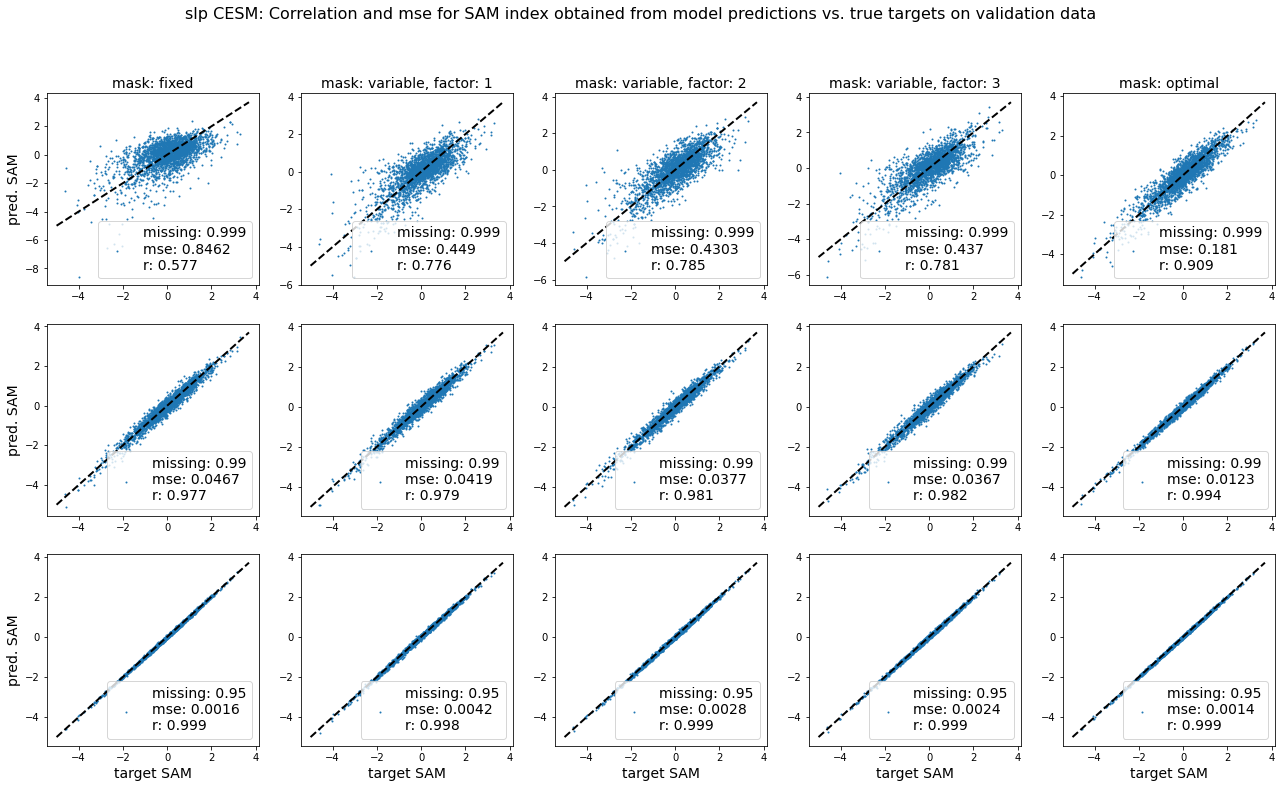

In [21]:
## slp CESM

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for SAM:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SAM_val_target_all[model_number,r,:n_samples], SAM_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SAM_val_target_all[model_number,r,:n_samples]-SAM_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SAM_val_target_all[model_number,r,:n_samples],SAM_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SAM', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SAM', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp CESM: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

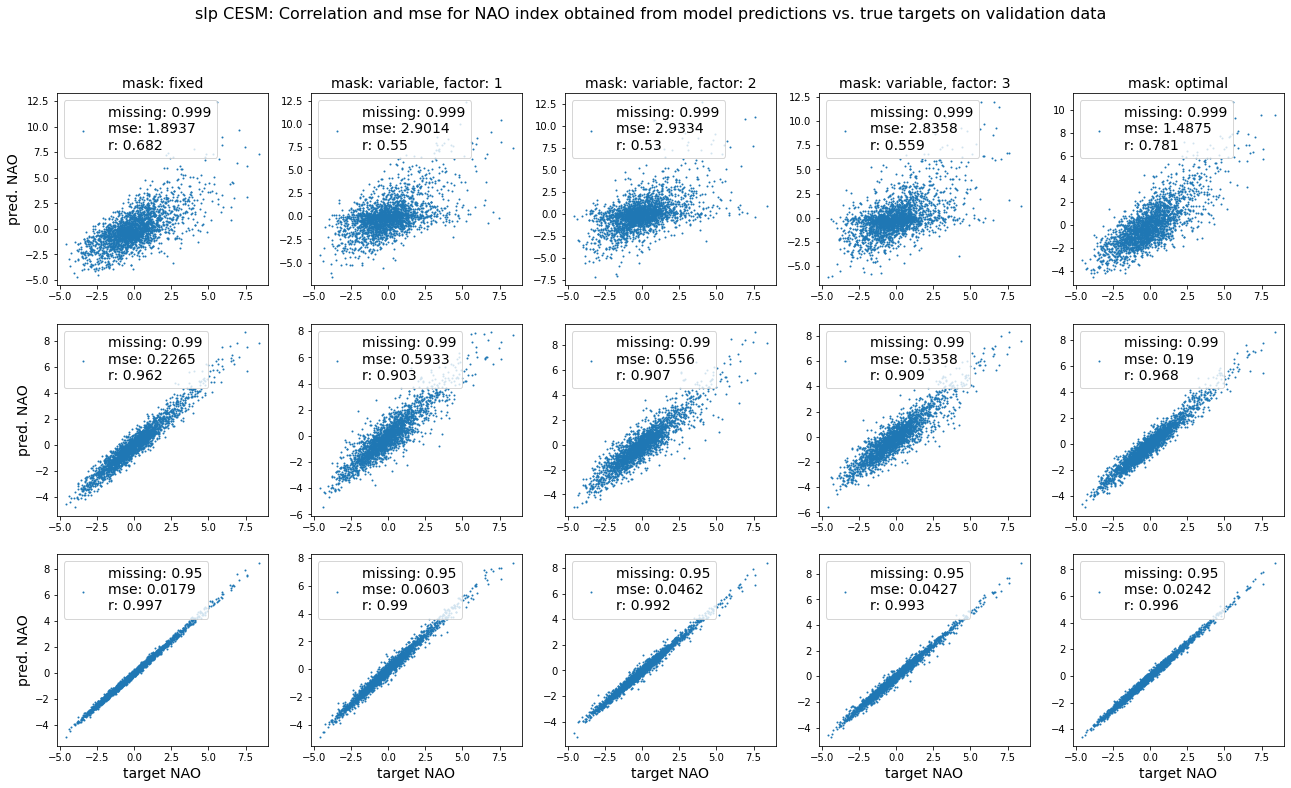

In [7]:
# Initialize plot for NAO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NAO_val_target_all[model_number,r,:n_samples], NAO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NAO_val_target_all[model_number,r,:n_samples]-NAO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NAO_val_target_all[model_number,r,:n_samples],NAO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NAO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NAO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('slp CESM: Correlation and mse for NAO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

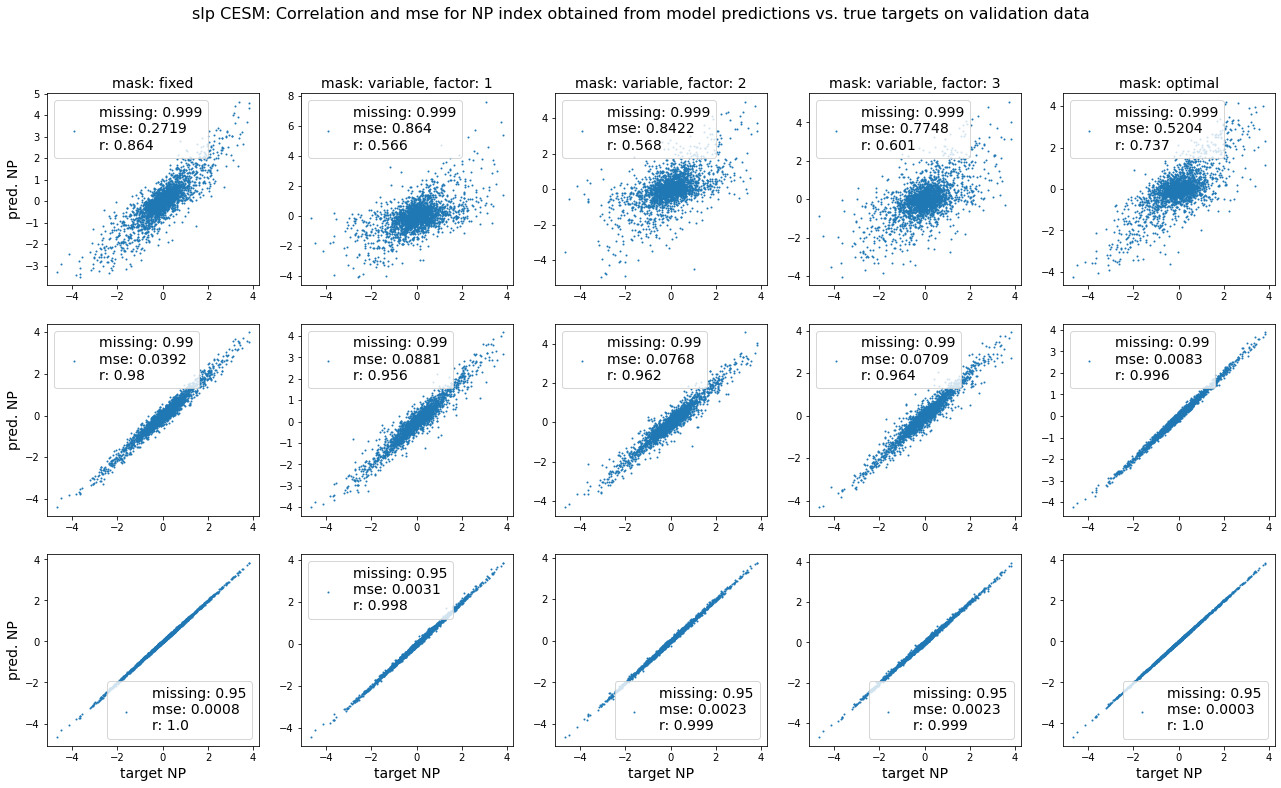

In [8]:
# Initialize plot for NP:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NP_val_target_all[model_number,r,:n_samples], NP_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NP_val_target_all[model_number,r,:n_samples]-NP_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NP_val_target_all[model_number,r,:n_samples],NP_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NP', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NP', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('slp CESM: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

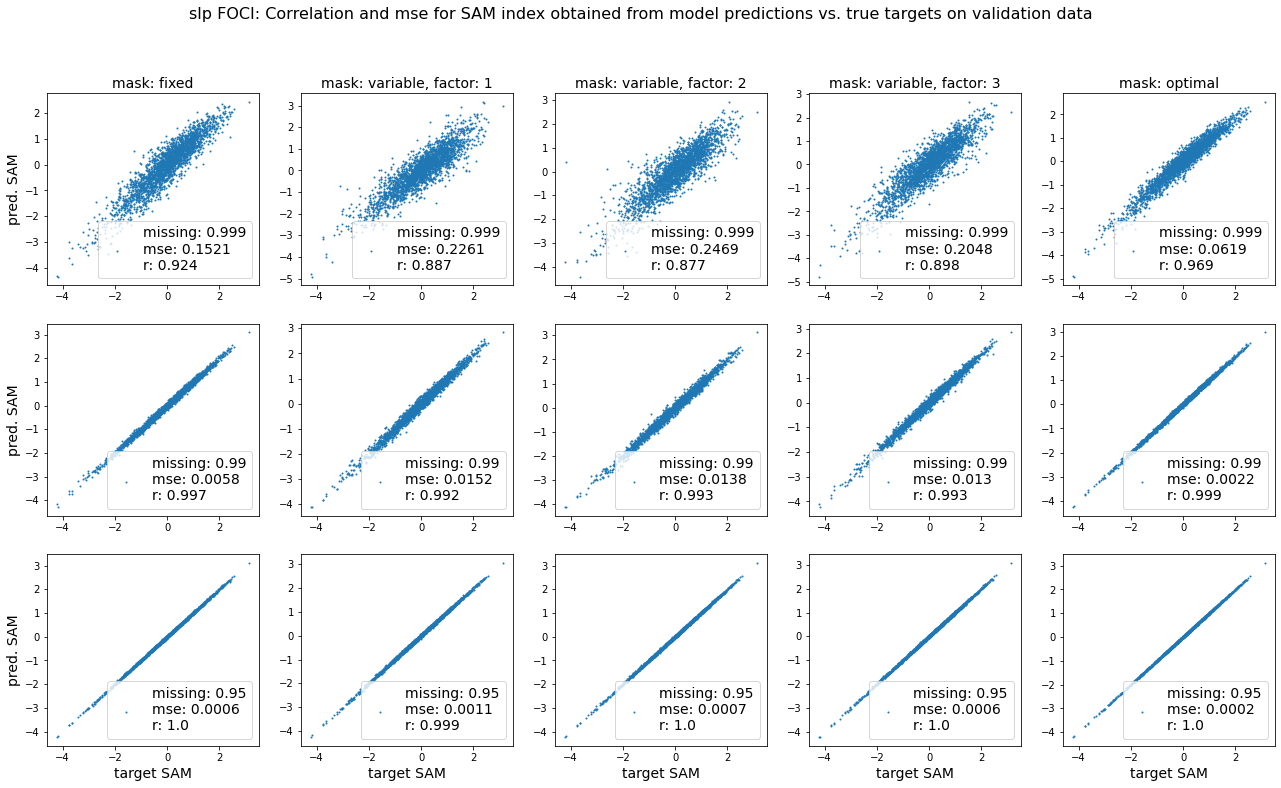

In [21]:
## slp FOCI

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for SAM:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SAM_val_target_all[model_number,r,:n_samples], SAM_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SAM_val_target_all[model_number,r,:n_samples]-SAM_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SAM_val_target_all[model_number,r,:n_samples],SAM_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SAM', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SAM', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('slp FOCI: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

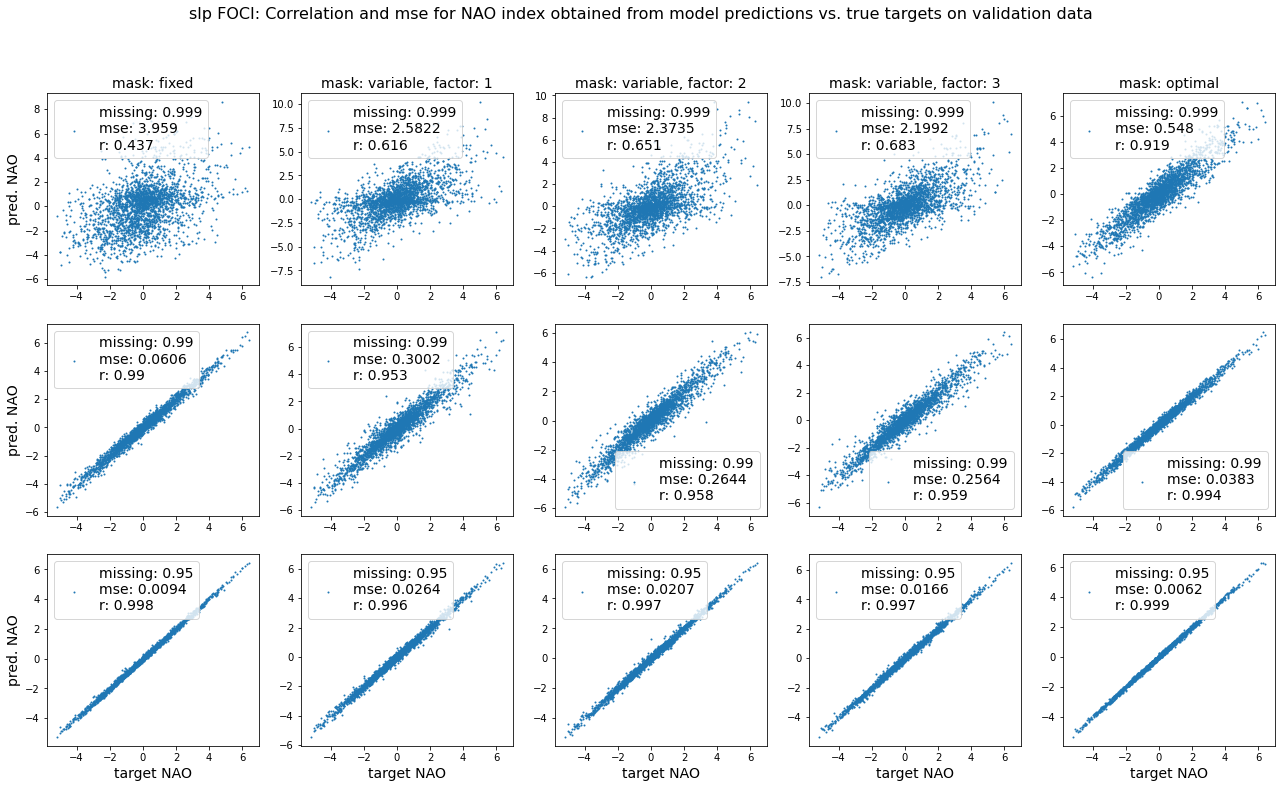

In [22]:
# Initialize plot for NAO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NAO_val_target_all[model_number,r,:n_samples], NAO_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NAO_val_target_all[model_number,r,:n_samples]-NAO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NAO_val_target_all[model_number,r,:n_samples],NAO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NAO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NAO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('slp FOCI: Correlation and mse for NAO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

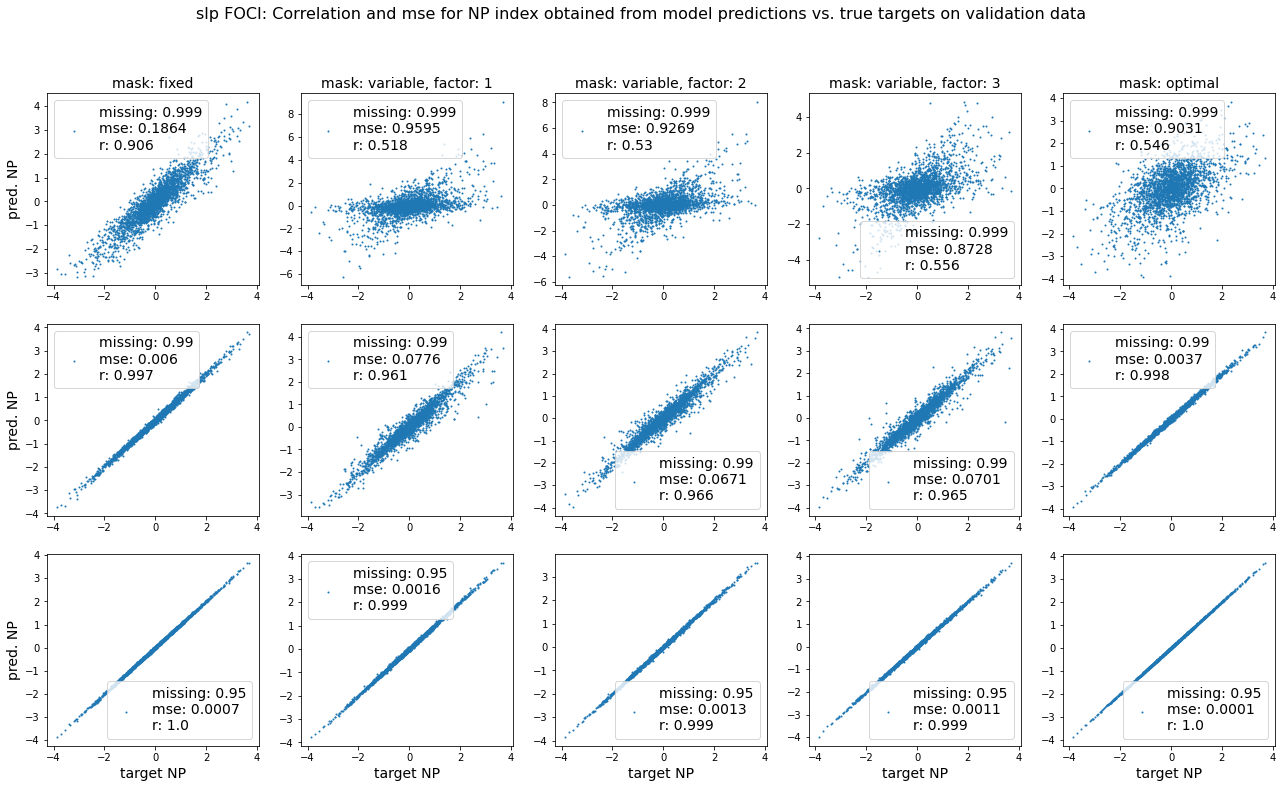

In [23]:
# Initialize plot for NP:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NP_val_target_all[model_number,r,:n_samples], NP_val_pred_all[model_number,r,:n_samples], s=1,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NP_val_target_all[model_number,r,:n_samples]-NP_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NP_val_target_all[model_number,r,:n_samples],NP_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NP', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NP', fontsize=14)
        axes[r,model_number].legend(fontsize=14)

fig.suptitle('slp FOCI: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

Text(0.5, 0.98, 'slp real world: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data')

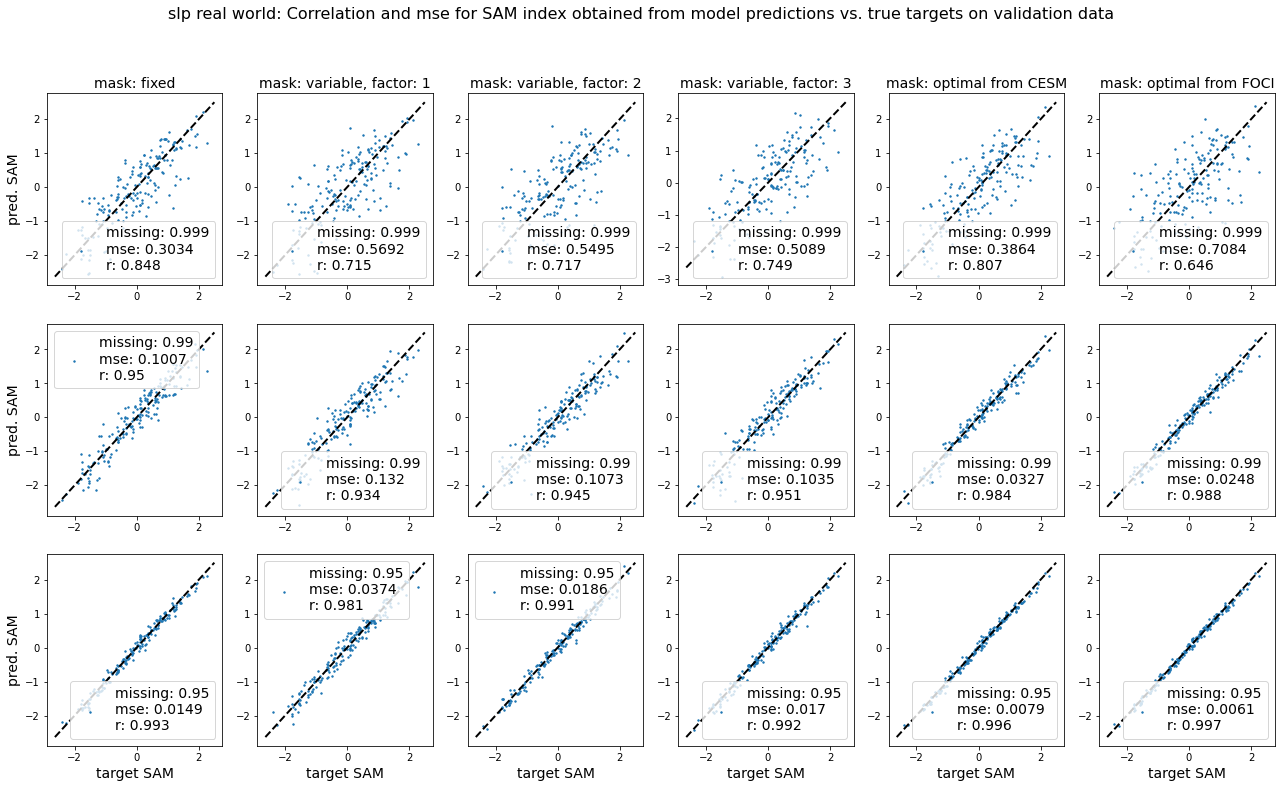

In [8]:
## slp real world

## Show scatterplot of indices obtained from model predictions vs. true targets (=complete samples).

# Set number of missing rates to include:
n_missing_rates = 3

# Set number of samples to include:
n_samples = n_val

# Initialize plot for SAM:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(SAM_val_target_all[model_number,r,:n_samples], SAM_val_pred_all[model_number,r,:n_samples], s=2,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((SAM_val_target_all[model_number,r,:n_samples]-SAM_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([SAM_val_target_all[model_number,r,:n_samples],SAM_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target SAM', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. SAM', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp real world: Correlation and mse for SAM index obtained from model predictions vs. true targets on validation data', fontsize=16)

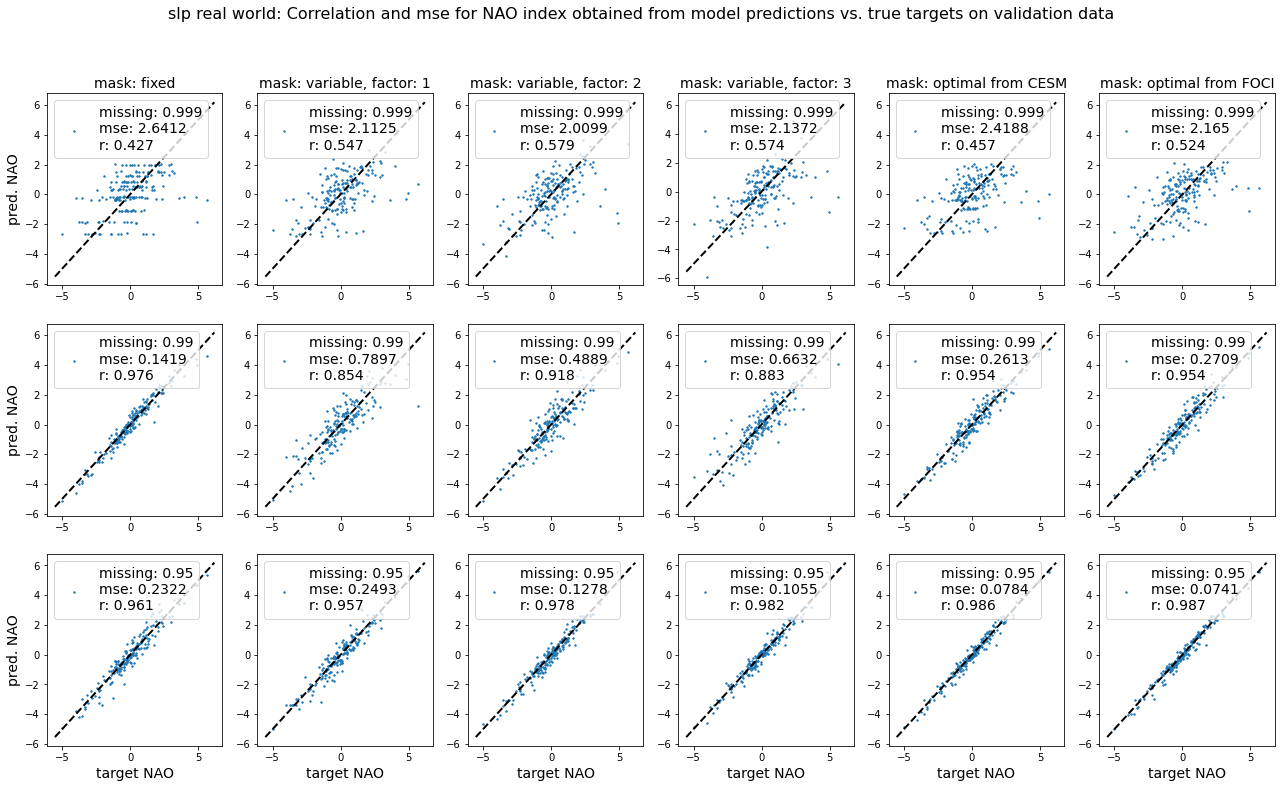

In [9]:
# Initialize plot for NAO:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NAO_val_target_all[model_number,r,:n_samples], NAO_val_pred_all[model_number,r,:n_samples], s=2,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NAO_val_target_all[model_number,r,:n_samples]-NAO_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NAO_val_target_all[model_number,r,:n_samples],NAO_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NAO', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NAO', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp real world: Correlation and mse for NAO index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

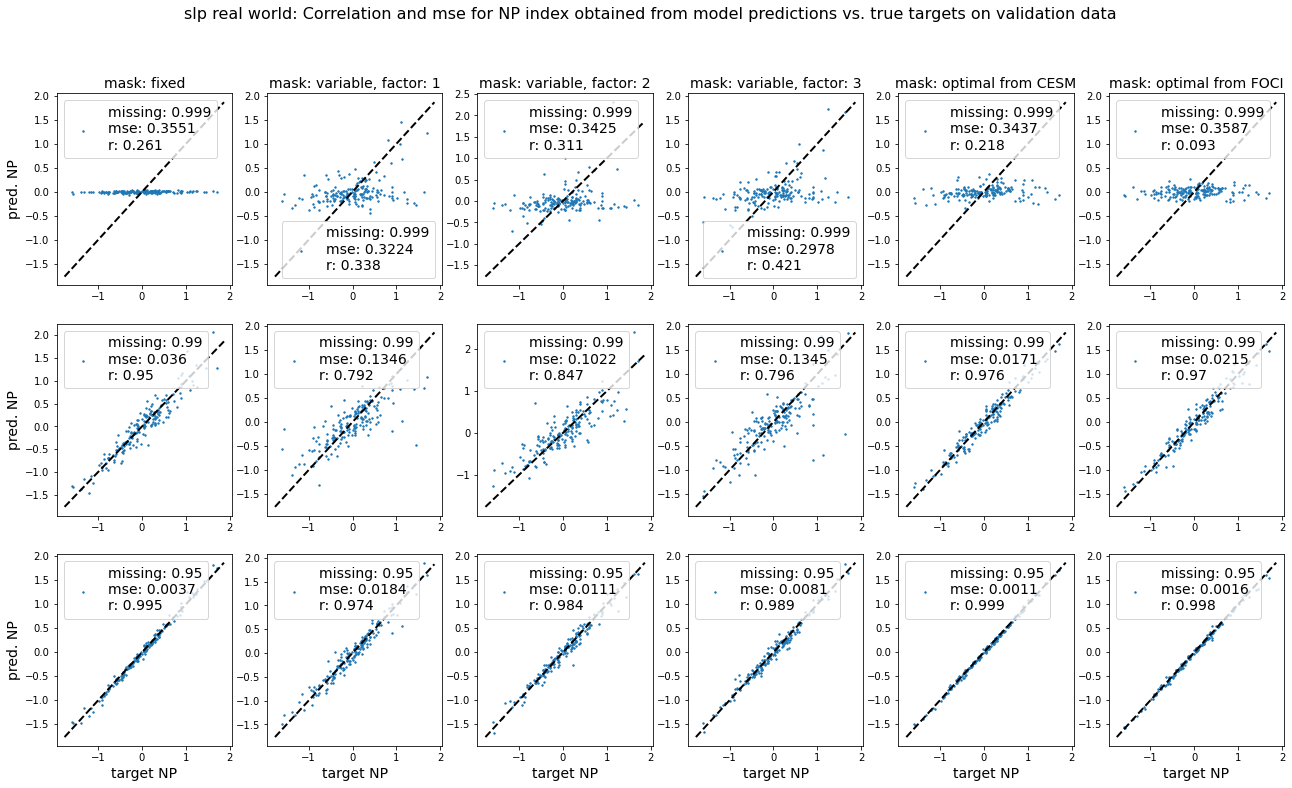

In [10]:
# Initialize plot for NP:
fig, axes = plt.subplots(n_missing_rates,len(model_shortnames),figsize=(22,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r,model_number].scatter(NP_val_target_all[model_number,r,:n_samples], NP_val_pred_all[model_number,r,:n_samples], s=2,
                                   label=
                                     'missing: '+str(missing_values_all[model_number][r])+'\nmse: '+
                                     str(np.round(np.mean(np.mean((NP_val_target_all[model_number,r,:n_samples]-NP_val_pred_all[model_number,r,:n_samples])**2)),4))+'\nr: '+
                                     str(np.round(np.corrcoef(np.stack([NP_val_target_all[model_number,r,:n_samples],NP_val_pred_all[model_number,r,:n_samples]]))[0,1],3))
                                    )
        if r == 0:
            axes[r,model_number].set_title(model_shortnames[model_number], fontsize=14)
        if r == n_missing_rates-1:
            axes[r,model_number].set_xlabel('target NP', fontsize=14)
        if model_number == 0:
            axes[r,model_number].set_ylabel('pred. NP', fontsize=14)
        axes[r,model_number].legend(fontsize=14)
        
        x = np.linspace(*axes[r,model_number].get_xlim())
        axes[r,model_number].plot(x, x, linestyle='--', color='k', lw=2)

fig.suptitle('slp real world: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

### Find samples that clearly show outperformance of optimal models for reconstructing from ultra sparse inputs

In [6]:
## Load data, get anomalies:

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"
    
    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields
    
    # When working with complete samples in spatial extend:
    # Remove last row (latidute), to have even number of steps in latitude (=72). This served as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    # This step is not essential for EOF, but keep it similar to U-Net approach.
    feature_anomaly = slp_anomaly_fields.values[:,:-1,:]
    
else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")[:n_time,:n_lat,:n_lon]

In [7]:
# Create synthetic missing_mask of ONEs, to load FULL validation samples:
missing_mask_1 = (np.ones(feature_anomaly.shape)==1)

# Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
_, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
    feature_anomaly, 
    missing_mask_1,
    train_val_split=train_val_split, 
    scale_to=scale_to
)

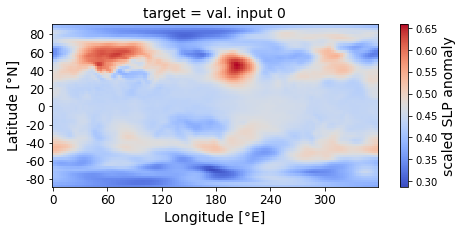

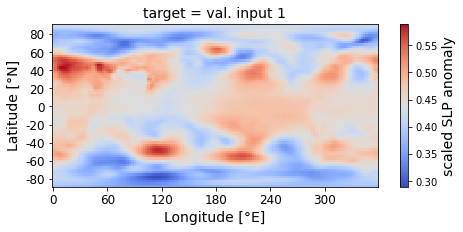

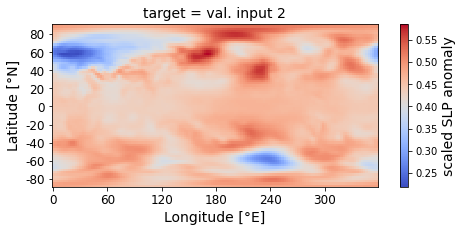

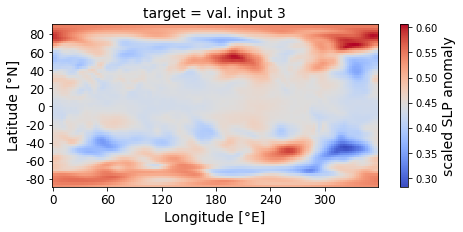

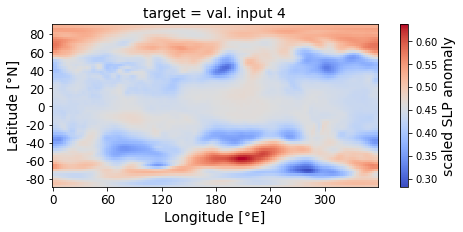

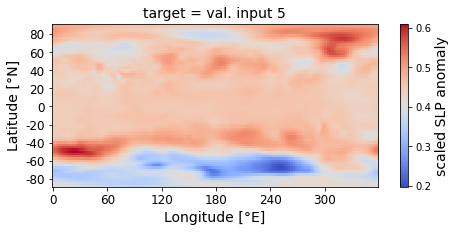

In [8]:
## Plot some validation targets (=complete samples):

# Specify number of samples to consider:
n_samples = 6

# Loop over samples:
for n in range(n_samples):
    
    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_target[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

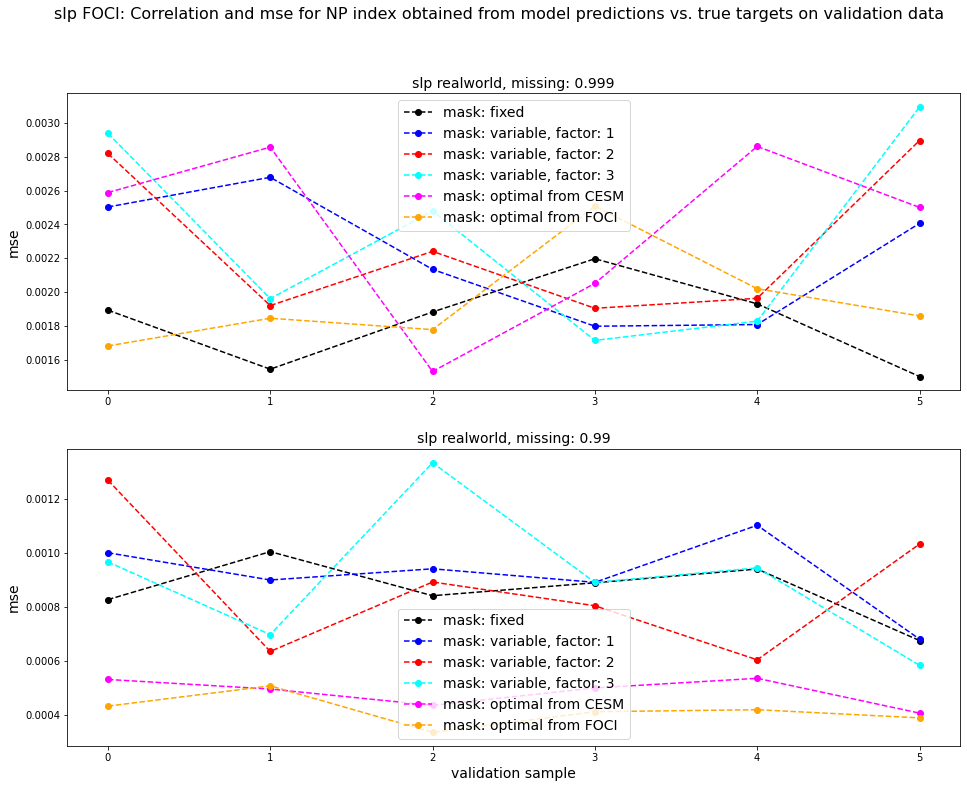

In [10]:
## Plot val. loss for several validation samples for all models and specified rates of missing values:

# Set number of missing rates to include:
n_missing_rates = 2

# Set colors and linestyles for individual models:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'orange']
linestyles = ['--', '--', '--', '--', '--', '--']

# Initialize plot:
fig, axes = plt.subplots(n_missing_rates,1,figsize=(16,12))

# Loop over rates of missing values:
for r in range(n_missing_rates):

    # Loop over models:
    for model_number in range(len(model_shortnames)):

        axes[r].plot(
            val_loss_per_sample_all[model_number,r,:n_samples],
            color=colors[model_number],
            label=model_shortnames[model_number],
            marker = 'o', linestyle = linestyles[model_number],
        )
                
        axes[r].set_title(feature_short+' '+source+', missing: '+str(missing_values_all[model_number][r]), fontsize=14)
        if r == n_missing_rates-1:
            axes[r].set_xlabel('validation sample', fontsize=14)
        axes[r].set_ylabel('mse', fontsize=14)
        axes[r].legend(fontsize=14)

fig.suptitle('slp FOCI: Correlation and mse for NP index obtained from model predictions vs. true targets on validation data', fontsize=16)
plt.show()

In [11]:
# For restoring missing masks, need seed for final models with fixed and variable masks.
# Got seeds from model comparison (notebook 01e), for 99.9% / 99% / 95% missing values.
seeds_all = [
    [2,3,2],
    [1,3,3],
    [2,3,2],
    [2,1,2]
]

In [12]:
## Pick validation sample 2:
sample_number = 2

# Initialize storage for model predictions. Dimension: (#models, #missing rates, lat, lon)
sample_pred_all = np.zeros((len(paths_to_final_models),n_missing_rates,val_input.shape[1],val_input.shape[2]))

# Loop over number of final models:
for m in range(len(paths_to_final_models)):
    
    # Get status:
    print('model ',m+1,' of ',len(paths_to_final_models))
    
    # Get current augmentation factor:
    augmentation_factor = augmentation_factor_all[m]
    
    # Extend feature anomalies, according to augmentation factor of current model:
    data = clone_data(data=feature_anomaly, augmentation_factor=augmentation_factor)
    
    # Loop over desired rates of missing values:
    for r in range(n_missing_rates):
        
        # Get status:
        print('  missing ',r+1,' of ',n_missing_rates)
    
        # Get current rate of missing values:
        missing = missing_values_all[m][r]
        
        # Reloading missing mask is only possible on nesh!
        # Alternatively: Restore missing mask, according to parameters.
        # For optimal models, need optimal masks from CESM and FOCI, to restore missing masks.
        if model_shortnames[m] == 'mask: optimal from CESM':

            # Set paths to optimal missing masks as strings:
            paths_to_missing_masks_string = [
                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_1',
                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_2',
                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_CESM_variable_range_50_999_factor_3_final/relevance_3',
            ]
            
            # Create paths to optimal missing masks as PosixPaths:
            paths_to_missing_masks = []
            for temp_path in paths_to_missing_masks_string:
                paths_to_missing_masks.append(Path(temp_path))

            # Reload optimal mask for missing values.
            # Rel. amount of missing values = 0.999 requires special treatment:
            if missing==0.999:
                filename_missing_mask = "optimal_sampling_mask_"+str(int(missing*1000))+"_realworld.npy"
                missing_mask = np.load(
                    paths_to_missing_masks[r] / filename_missing_mask
                )
            else:
                filename_missing_mask = "optimal_sampling_mask_"+str(int(missing*100))+"_realworld.npy"
                missing_mask = np.load(
                    paths_to_missing_masks[r] / filename_missing_mask
                )
    
            # Expand missing mask to have sample dimension as first dimension, then repeat. Dimensions: (#samples, lat, lon).
            missing_mask = np.repeat(np.expand_dims(missing_mask,axis=0),data.shape[0], axis=0)
            
        elif model_shortnames[m] == 'mask: optimal from FOCI':

            # Set paths to optimal missing masks as strings:
            paths_to_missing_masks_string = [
                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_1',
                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_2',
                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_3',
            ]
            
            # Create paths to optimal missing masks as PosixPaths:
            paths_to_missing_masks = []
            for temp_path in paths_to_missing_masks_string:
                paths_to_missing_masks.append(Path(temp_path))

            # Reload optimal mask for missing values.
            # Rel. amount of missing values = 0.999 requires special treatment:
            if missing==0.999:
                filename_missing_mask = "optimal_sampling_mask_"+str(int(missing*1000))+"_realworld.npy"
                missing_mask = np.load(
                    paths_to_missing_masks[r] / filename_missing_mask
                )
            else:
                filename_missing_mask = "optimal_sampling_mask_"+str(int(missing*100))+"_realworld.npy"
                missing_mask = np.load(
                    paths_to_missing_masks[r] / filename_missing_mask
                )
    
            # Expand missing mask to have sample dimension as first dimension, then repeat. Dimensions: (#samples, lat, lon).
            missing_mask = np.repeat(np.expand_dims(missing_mask,axis=0),data.shape[0], axis=0)
            
        # For final models, trained on fixed and variable masks, restore missing mask:
        else:
                
            # Create mask for missing values:
            missing_mask = create_missing_mask(
                data=data,
                mask_type=mask_type_all[m],
                missing_type=missing_type_all[m],
                missing_min=missing,
                missing_max=missing,
                seed=seeds_all[m][r],
            )
            
        # Get scaled validation inputs and targets.
        _, val_input, _, val_target, train_min, train_max, _, _ = split_and_scale_data(
            data, 
            missing_mask,
            train_val_split=train_val_split, 
            scale_to=scale_to
        )
        
        # Pick desired sample and target:
        sample = val_input[sample_number*augmentation_factor:sample_number*augmentation_factor+1]
        
        ## Reload final pre-trained model for current rate of missing values.
        
        # Set path:
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*1000)}" + "/model"
        else:
            model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*100)}" + "/model"
        
        # Reload model
        model = tf.keras.models.load_model(Path(model_path))
            
        # Get model prediction for desired sample and 
        # store model prediction for current final model and current rate of missing values:
        sample_pred_all[m,r] = model.predict(sample)[0,:,:,0]


model  1  of  6
  missing  1  of  2


2023-02-24 14:08:22.127569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-24 14:08:22.128829: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-24 14:08:22.129078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (30ab6f407038): /proc/driver/nvidia/version does not exist
2023-02-24 14:08:22.136891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 14:08:29.986260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the M

  missing  2  of  2
model  2  of  6
  missing  1  of  2
  missing  2  of  2
model  3  of  6
  missing  1  of  2
  missing  2  of  2
model  4  of  6
  missing  1  of  2
  missing  2  of  2
model  5  of  6
  missing  1  of  2
  missing  2  of  2
model  6  of  6
  missing  1  of  2
  missing  2  of  2


In [34]:
# Pick model number and missing rate:
m = 0
r = 0

# Get current rate of missing values:
missing = missing_values_all[m][r]

if missing==0.999:
    model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*1000)}" + "/model"
else:
    model_path = paths_to_final_models[m] + "/missing_" f"{int(missing*100)}" + "/model"

print(model_path)

# Reload model
model = tf.keras.models.load_model(Path(model_path))

# Get model prediction for desired sample and 
# store model prediction for current final model and current rate of missing values:
sample_pred = model.predict(np.expand_dims(np.expand_dims(sample_pred_all[m,r],axis=0),axis=-1))[0,:,:]

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_realworld_fixed_discrete_factor_1_final/missing_999/model


In [36]:
sample_pred = model.predict(np.expand_dims(np.expand_dims(sample_pred_all[m,r],axis=0),axis=-1))[0,:,:]

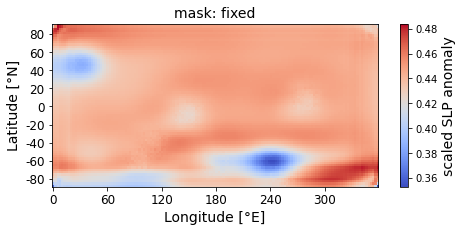

In [38]:
# Plot model reconstructions for current rate of missing values:
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(sample_pred, cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)
plt.title(model_shortnames[m], fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

0.999  missing



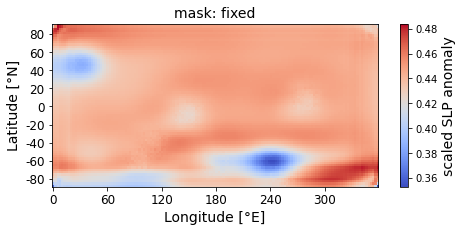

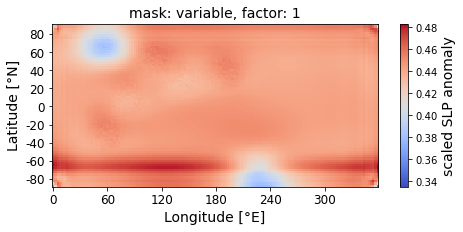

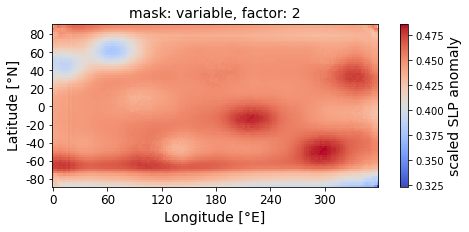

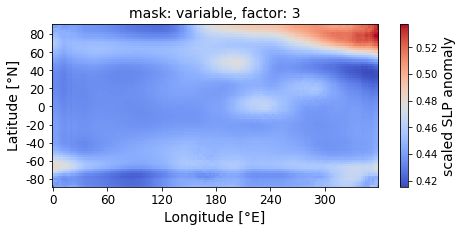

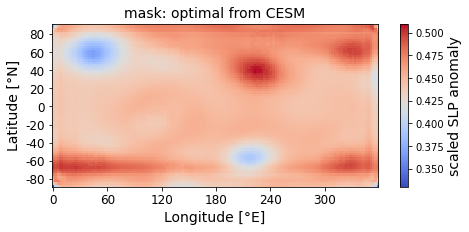

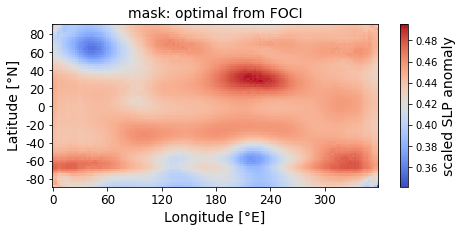

0.99  missing



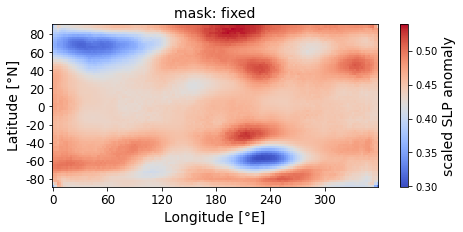

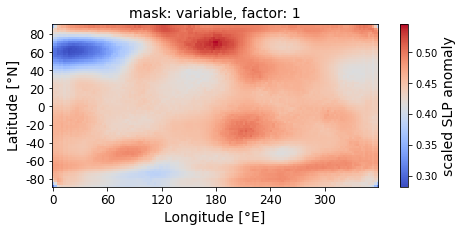

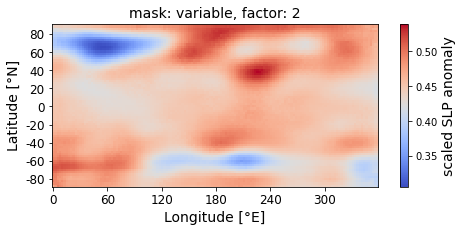

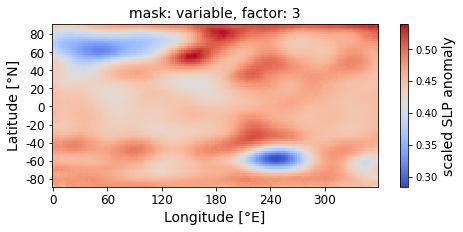

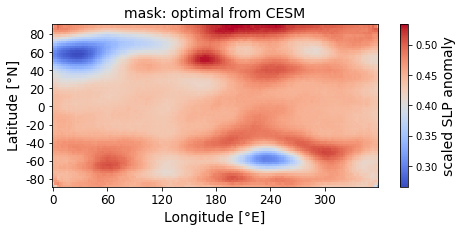

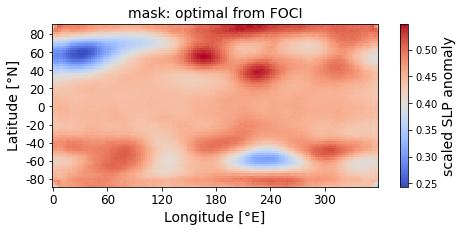

In [13]:
# Plot for all included rates of missing values (column) all reconstructions from final models (row) plus target.
# Plot - if available - DINEOF reconstruction (99% and 95% missing, only).

# Loop over rates of missing values:
for r in range(n_missing_rates):
    
    # Loop over models:
    for m in range(len(model_shortnames)):

        # Print current rate of missing values:
        if m == 0:
            print(missing_values_all[m][r],' missing\n')
            
        # Plot model reconstructions for current rate of missing values:
        fig, ax = plt.subplots(figsize=(8, 3))
        im = plt.imshow(sample_pred_all[m,r], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
        cbar = plt.colorbar(im)
        cbar.set_label("scaled SLP anomaly", fontsize=14)
        plt.title(model_shortnames[m], fontsize=14)
        plt.xlabel('Longitude [°E]', fontsize=14)
        plt.ylabel('Latitude [°N]', fontsize=14)
        plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
        plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

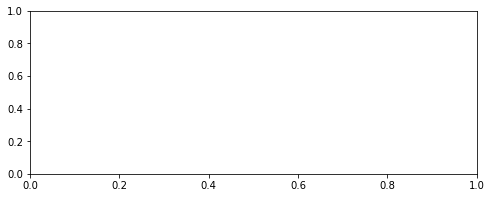

In [14]:
## Plot target:
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(val_target[sample*augmentation_factor], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("scaled SLP anomaly", fontsize=14)
plt.title(model_shortnames[m], fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

